> Igor Sorochan DSU-31

## Classification: Logistic regression. Support vector machine.

### Environment

In [1]:
import numpy as np, pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline ,Pipeline#, FeatureUnion
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, PowerTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV # GridSearchCV
from sklearn.svm import SVC

# from sklearn.decomposition import PCA
# from sklearn.feature_selection import SelectKBest

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# from warnings import simplefilter
# from sklearn.exceptions import ConvergenceWarning
# simplefilter("ignore", category=ConvergenceWarning)
# warnings.filterwarnings('ignore')

#### Loading data

In [2]:
df_raw = pd.read_csv('/Users/velo1/SynologyDrive/GIT_syno/data/adult.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


### EDA
#### NaNs and noise

In [3]:
df_raw.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


There is some noise in data, e.g. '?'.  
Lets dig into.  
Dividing columns on data types:

In [ ]:
# select all categorical columns
X_cat = df_raw.select_dtypes(include=['object'])
# select all numeric columns
X_num = df_raw.select_dtypes(include=['int64', 'float64','uint8'])

In [5]:
for col in X_cat:
  print(col.ljust(15),sorted(set(X_cat[col].values)))

workclass       ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']
education       ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college']
marital-status  ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']
occupation      ['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']
relationship    ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife']
race            ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White']
gender          ['Female', 'Male']
native-country  ['?', 'Cambodia',

* `workclass, occupation, native-country` columns contain '?'
* `target` column contains only two values.  So it will be **the binary classification problem.**

Lets assume there is some meaning in the presence of symbol '?' in data.  
For example, if occupation and native-country ary unknown there might be greater probability of low income.

In [6]:
# filtering columns on whitespaces, dots and underscore symbols
mask = X_cat.apply(lambda x: x.str.contains('[\s?._ ]')).any(axis=1)
rows = df_raw[mask]
rows.sample(3)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
40464,49,?,57665,Bachelors,13,Divorced,?,Own-child,White,Female,0,0,40,United-States,<=50K
19509,32,?,53042,HS-grad,9,Never-married,?,Own-child,Black,Male,0,0,40,United-States,<=50K
12421,17,?,387063,10th,6,Never-married,?,Own-child,White,Female,0,0,20,United-States,<=50K


#### Duplicates

There are 52 duplicates.  
Dropping duplicates.

In [7]:
df_raw.duplicated().value_counts()

False    48790
True        52
dtype: int64

In [8]:
df_raw.drop_duplicates(inplace= True)

In [9]:
df_raw.duplicated().sum()

0

#### Checking for zeros and negative values

In [10]:
mask = X_num.apply(lambda x: x < .5).any(axis=1) 
rows = df_raw[mask]
rows.sample(3)

/var/folders/qw/qq8zb5hx0w9cgzgkf9_v2sh00000gq/T/ipykernel_72680/2928447756.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rows = df_raw[mask]


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
43471,43,State-gov,241506,Bachelors,13,Divorced,Prof-specialty,Unmarried,White,Female,1506,0,36,United-States,<=50K
22870,25,Private,175370,Some-college,10,Divorced,Machine-op-inspct,Own-child,White,Female,0,0,40,United-States,<=50K
35208,35,Private,322171,Some-college,10,Married-civ-spouse,Other-service,Wife,White,Female,0,0,40,United-States,>50K


Zeros present at capital-* columns.  

**Lets leave data as it is.**

#### Visualizing the input data

Let's look at the variable distributions and at the pairwise relationships between them.

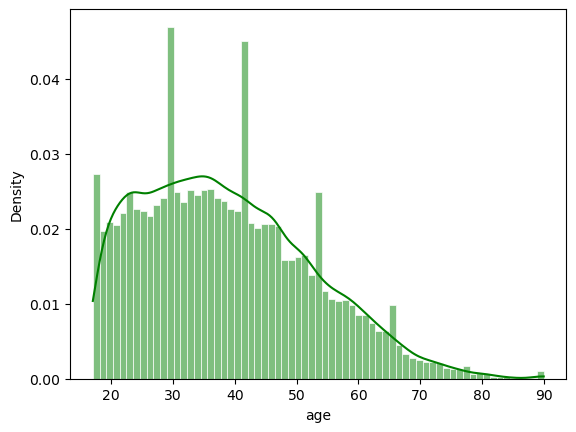

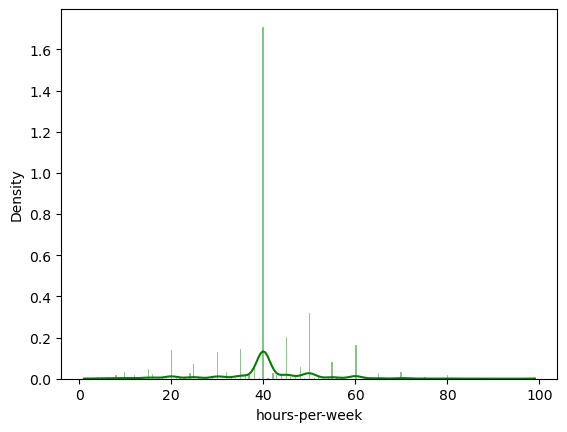

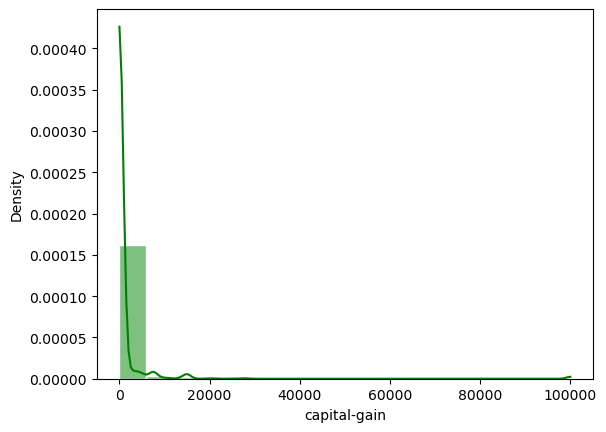

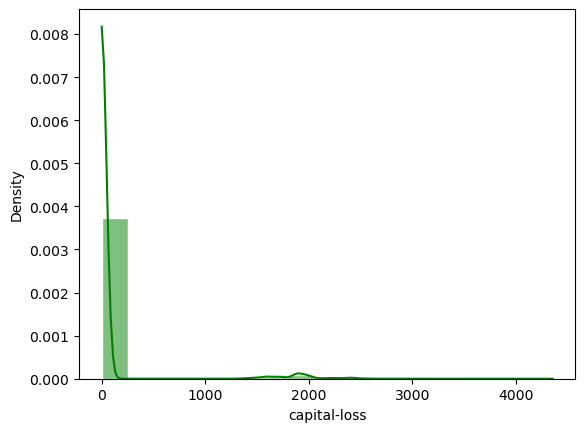

In [11]:
# fig, axs = plt.subplots(2,3)
for i,col in enumerate(['age','hours-per-week','capital-gain','capital-loss']):
    sns.histplot(df_raw[col], kde=True,  stat="density", color='g' ,edgecolor= (1,)*4, label= col)
    plt.show()

`capital-loss` and `capital-gain` have a very long tail.  

**The preprocessing in this case is a must.**

In [12]:
# sns.pairplot(df_raw, kind="reg", diag_kind="kde")
# plt.show()

In [13]:
# plt.rcParams['lines.markersize'] = 1
# plt.scatter(df_raw['fnlwgt'], df_raw.age)

# "fnlwgt" stands for "final weight." The final weight is a numerical value assigned to each person in a survey or sample 
# to adjust for biases in the data collection process. The weight is used to make the sample representative of the target population,
#  so that statistical inferences can be made about the population based on the sample data. 
# The final weight is calculated using a complex formula that takes into account various factors such as the design of the survey, 
# the size of the target population, and the characteristics of the respondents. 

fig = px.histogram(df_raw, x= 'race',   color='gender', barmode= 'group')
# fig.update_traces(marker_line_width=1,marker_line_color="white")
fig.update_layout(xaxis={'categoryorder':'total descending'})

There are much more *white males* than other groups.  
We assume there is some bias here.

In [14]:
df_raw[['race', 'gender']].value_counts()

race                gender
White               Male      28703
                    Female    13011
Black               Male       2375
                    Female     2308
Asian-Pac-Islander  Male       1000
                    Female      517
Amer-Indian-Eskimo  Male        285
Other               Male        251
Amer-Indian-Eskimo  Female      185
Other               Female      155
dtype: int64

In [15]:
fig = px.histogram(df_raw, x='marital-status', color='gender', height= 700, title= "The distribution of marital-status",
        barmode= 'group', opacity=0.5 ,color_discrete_map = {'Male':'blue','Female':'red'})
fig.update_traces(marker_line_width=1,marker_line_color="white")
fig.update_layout(xaxis={'categoryorder':'total descending'})

More males were married to a civil spouse as there are far fewer women in the military.  
It's normal.

##### Feature correlations

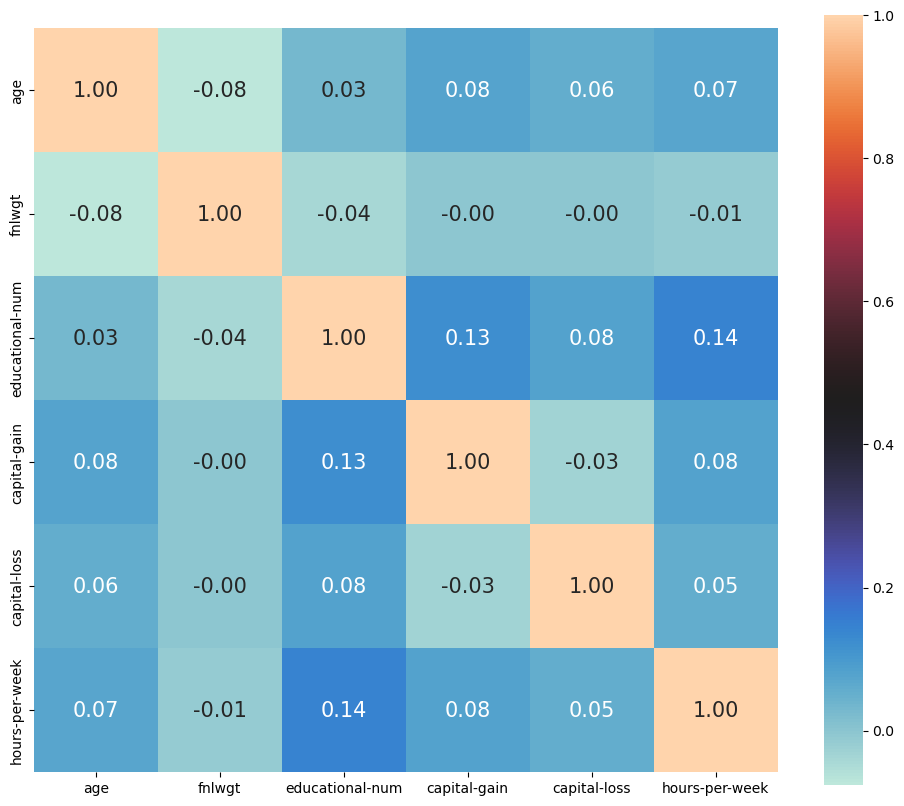

In [16]:
df_corr = df_raw.corr(numeric_only= True)
# Plotting the heatmap of correlation between features
plt.figure(figsize=(12,10))
sns.heatmap(df_corr, cbar=True, square= True, fmt='.2f', annot=True, annot_kws={'size':15}, cmap='icefire')
plt.show()

There is `no correlation` between numeric features.

### `Defining target labels and features`

In [17]:
y = df_raw['income'] # as a pd.Series
X = df_raw.drop('income', axis= 1)

Figuring out classes imbalance.

In [18]:
px.bar(y.value_counts(), width= 500, title= "Target label imbalance")

The imbalance is present, but acceptable.
Lets encode the target variable.

In [19]:
le = LabelEncoder() 
le.fit(y)
le.classes_

array(['<=50K', '>50K'], dtype=object)

In [20]:
y_transformed = pd.Series(data= le.transform(y))

Transforming features

In [21]:
X = pd.get_dummies(X, columns= X_cat.columns.drop('income'), drop_first=True, sparse= False)
# X.info()

## Splitting data

In [22]:
# y_transformed.head()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size= 0.2, random_state= 45)

## Logistic regression pipeline

##### Without preprocessing

In [24]:
log_regr = make_pipeline(
    # PowerTransformer(),
    LogisticRegression()
)
log_regr.fit(X_train, y_train)
print(f'Train score:{log_regr.score(X_train, y_train)}')
print(f'Test score: {log_regr.score(X_test, y_test)}')

Train score:0.7956036072965772
Test score: 0.8051854888296782


##### Performance with different Scalers

In [25]:
# The utility function make_pipeline is a shorthand for constructing pipelines; 
# it takes a variable number of estimators and returns a pipeline, filling in the names automatically
log_regr = make_pipeline(
    MinMaxScaler(),
    LogisticRegression()
)
log_regr.fit(X_train, y_train)
print(f'Train score:{log_regr.score(X_train, y_train)}')
print(f'Test score: {log_regr.score(X_test, y_test)}')

Train score:0.8501485960237753
Test score: 0.8586800573888091


/Users/velo1/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [26]:
log_regr = make_pipeline(
    RobustScaler(),
    LogisticRegression()
)
log_regr.fit(X_train, y_train)
print(f'Train score:{log_regr.score(X_train, y_train)}')
print(f'Test score: {log_regr.score(X_test, y_test)}')

Train score:0.8438204550112728
Test score: 0.8481246156999385


/Users/velo1/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [27]:
log_regr = make_pipeline(
    PowerTransformer(),
    LogisticRegression()
)
log_regr.fit(X_train, y_train)
print(f'Train score:{log_regr.score(X_train, y_train)}')
print(f'Test score: {log_regr.score(X_test, y_test)}')

Train score:0.8450245952039352
Test score: 0.8505841360934617


In [28]:
log_regr = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)
log_regr.fit(X_train, y_train)
print(f'Train score:{log_regr.score(X_train, y_train)}')
print(f'Test score: {log_regr.score(X_test, y_test)}')

Train score:0.851506456241033
Test score: 0.8588850174216028


In [29]:
log_regr = make_pipeline(
    RobustScaler(),
    LogisticRegression(max_iter= 1e3)
)
log_regr.fit(X_train, y_train)
print(f'Train score:{log_regr.score(X_train, y_train)}')
print(f'Test score: {log_regr.score(X_test, y_test)}')

Train score:0.8505841360934617
Test score: 0.8583726173396188


Test score is almost identical  
but StandardScaler performed a little better.

#### Performing randomized search for best parameters

Chaining Best Scaler and Logistic Regression with tuning hyperparameters

In [30]:
%%time

# Define a Standard Scaler to normalize inputs
# scaler = RobustScaler()
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
lr = LogisticRegression(max_iter= 1000, tol=0.05)
pipe = Pipeline(steps=[ 
                       ("scaler", scaler)
                       ,("logistic", lr)])


# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "logistic__penalty":['l2', 'l1'],
    # "logistic__penalty": ['elasticnet'],
    # "logistic__l1_ratio": uniform(0, 1),    # # from scipy.stats import uniform # distributions in 
    "logistic__C": np.logspace(-4, 4, 6),
    # "logistic__class_weight": ['balanced', None],
    "logistic__solver": [ 'lbfgs','saga'] #'lbfgs','saga'
}
search = RandomizedSearchCV(pipe, param_grid, n_jobs=2, verbose= 0)
# print([{x:y} for (x,y) in search.get_params().items() if 'logistic' in x])
search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:0.5f}")
print(search.best_params_)

pd.DataFrame(search.cv_results_)

/Users/velo1/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/velo1/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/velo1/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/velo1/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    s

Best parameter (CV score=0.85079
{'logistic__solver': 'lbfgs', 'logistic__penalty': 'l2', 'logistic__C': 10000.0}
CPU times: user 5.69 s, sys: 413 ms, total: 6.11 s
Wall time: 21.9 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__solver,param_logistic__penalty,param_logistic__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.205670,0.012597,0.000000,0.000000,lbfgs,l1,0.0001,"{'logistic__solver': 'lbfgs', 'logistic__penal...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
1,0.227367,0.008360,0.000000,0.000000,lbfgs,l1,251.188643,"{'logistic__solver': 'lbfgs', 'logistic__penal...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2,0.883386,0.146965,0.029735,0.004286,saga,l2,0.158489,"{'logistic__solver': 'saga', 'logistic__penalt...",0.840656,0.844755,0.847937,0.844350,0.851140,0.845768,0.003542,3
3,1.052910,0.275645,0.023186,0.007896,saga,l1,0.158489,"{'logistic__solver': 'saga', 'logistic__penalt...",0.841040,0.844883,0.847041,0.843838,0.851012,0.845563,0.003340,6
4,0.748955,0.077683,0.015404,0.002497,saga,l1,10000.0,"{'logistic__solver': 'saga', 'logistic__penalt...",0.840528,0.845011,0.848066,0.844094,0.851012,0.845742,0.003567,4
5,0.384737,0.050383,0.020234,0.002400,saga,l1,0.0001,"{'logistic__solver': 'saga', 'logistic__penalt...",0.759447,0.759319,0.759416,0.759416,0.759416,0.759403,0.000044,7
6,0.160647,0.007086,0.000000,0.000000,lbfgs,l1,6.309573,"{'logistic__solver': 'lbfgs', 'logistic__penal...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
7,0.705842,0.081727,0.021796,0.007828,saga,l2,251.188643,"{'logistic__solver': 'saga', 'logistic__penalt...",0.840784,0.844883,0.848322,0.844350,0.851781,0.846024,0.003741,2
8,1.094253,0.135510,0.029602,0.007585,lbfgs,l2,10000.0,"{'logistic__solver': 'lbfgs', 'logistic__penal...",0.846676,0.849878,0.851781,0.851268,0.854343,0.850789,0.002513,1
9,0.668894,0.094109,0.017268,0.002964,saga,l2,6.309573,"{'logistic__solver': 'saga', 'logistic__penalt...",0.840656,0.844755,0.847937,0.844094,0.851012,0.845691,0.003525,5


In [31]:
# load best params and
pipe.set_params(**search.best_params_)
# increase iteration limit
pipe.set_params(logistic__max_iter= 3e3) #logistic__tol = 1e-3, 
pipe.fit(X_train, y_train)
print(f'Train score:{pipe.score(X_train, y_train):.6f}')
print(f'Test score: {pipe.score(X_test, y_test):.6f}')
print('-'*50)
print(pipe['scaler'])
search.best_params_

Train score:0.851660
Test score: 0.858885
--------------------------------------------------
StandardScaler()


{'logistic__solver': 'lbfgs',
 'logistic__penalty': 'l2',
 'logistic__C': 10000.0}

Manual checking the accuracy score.

In [32]:
df_test =pd.DataFrame({'Predicted':pipe.predict(X_test), 'GT':y_test})
print(f'Accuracy :{sum(df_test.Predicted == df_test.GT)/df_test.shape[0]:.5f}')

Accuracy :0.85889


In [33]:
df_test

,Predicted,GT
14369,0,0
22867,0,0
26139,0,1
15057,1,1
1755,0,0
...,...,...
19090,0,0
34266,1,1
44609,0,1
41149,1,1


Tweaking the hyperparamaters doesn't make sensible results.

## SVC pipeline

Without preprocessing

In [34]:
svc_rs = make_pipeline(
    # StandardScaler(),
    SVC()
)
svc_rs.fit(X_train, y_train)
print(f'Train score:{svc_rs.score(X_train, y_train)}')
print(f'Test score: {svc_rs.score(X_test, y_test)}')
#exec time  6 min

Train score:0.796858987497438
Test score: 0.8038532486165197


In [35]:
svc_rs = make_pipeline(
    StandardScaler(),
    SVC()
)
svc_rs.fit(X_train, y_train)
print(f'Train score:{svc_rs.score(X_train, y_train)}')
print(f'Test score: {svc_rs.score(X_test, y_test)}')
#exec time  5 min

Train score:0.860832137733142
Test score: 0.8542734166837467


In [36]:
# svc_rs.get_params()

The following cell execution time is more than 1 hour.  
The output results are so so.

In [37]:
# %%time

# scaler = StandardScaler()
# svc = SVC()

# pipe = Pipeline(steps=[ 
#                        ("scaler", scaler)
#                        ,("svc", svc)])


# # Parameters of pipelines can be set using '__' separated parameter names:
# param_grid = {

#     "svc__kernel":['linear'], # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' 
#     # "svc__class_weight": ["balanced"],  
#     "svc__C":[6.3],
# }
# search = RandomizedSearchCV(pipe, param_grid, n_jobs= 2, verbose= 10)
# # print([{x:y} for (x,y) in search.get_params().items() if 'svc' in x])
# search.fit(X_train, y_train)

# print(f"Best parameter (CV score={search.best_score_:0.5f}")
# print(search.best_params_)

# pd.DataFrame(search.cv_results_)

# # exec.time 73min

In [38]:
# print(search.best_params_)

In [39]:
# print([{x,y} for (x,y) in search.get_params().items() if 'svc' in x])

In [40]:
# load best params and
# pipe.set_params(**search.best_params_)


df_test =pd.DataFrame({'Predicted':svc_rs.predict(X_test), 'GT':y_test})
print(f"Best parameter (CV score={svc_rs.score(X_test, y_test):0.5f})")
df_test.sample(5)
#exec time 1min

Best parameter (CV score=0.85427)


,Predicted,GT
24706,1,1
23704,1,0
12646,0,0
2865,0,0
32272,0,0


In [41]:
print(f'Accuracy (manual calculation):  {sum(df_test.Predicted == df_test.GT)/df_test.shape[0]:.5f}')

Accuracy (manual calculation):  0.85427


### Let's try some feature engineering

In [42]:
# PolynomialFeatures  - Generate polynomial and interaction features.
polynomial_features = PolynomialFeatures(degree=2, interaction_only= False) 
X_poly = polynomial_features.fit_transform(X) 
X_poly.shape, X.shape

((48790, 5151), (48790, 100))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y_transformed, test_size= 0.2, random_state= 0)

In [44]:
%%time

log_regr = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)
log_regr.fit(X_train, y_train)
print(f'Train score:{log_regr.score(X_train, y_train)}')
print(f'Test score: {log_regr.score(X_test, y_test)}')

/Users/velo1/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Train score:0.8721305595408895
Test score: 0.8543758967001435
CPU times: user 3min, sys: 5.9 s, total: 3min 6s
Wall time: 32.3 s


# Main takeouts:
| model| train score | test score | exec time|
|:---|:---|:---|:---|
|LogRegr|0.7956|0.8051|0.5 s|
|Standardscaler + LogRegr|0.8515|**0.8588**|0.5 s|
|Minmaxscaler + LogRegr|0.8501|0.8586|0.8 s|
|Robustscaler + LogRegr|0.8438|0.8481|0.8 s|
|Powertransformer + LogRegr|0.8450|0.8506|2.7 s|
|SVC|0.7968|0.8038|6 min|
|Standardscaler + SVC|0.8608|0.8542|4 min|
|StSc + PolynFeat(n=2)+LogRegr|**0.8721**|0.8544|33 s|
|StSc + PolynFeat(n=3)+LogRegr|||crashed|

* SVC models are `much slower` performing on this particular dataset.
* Transforming observations with **polynomial features** (n=2) steer **to overfitting**  (`0.872` on train set and decent `0.854` on test set).  
PolynomialFeatures(n=2) + Standardscaler + LogRegr model works out with time complexity O(n2).
* Tweaking LR hyperparameters doesn't help at least with RandomizedSearchCV (I didn't use exhaustive GridSearchCV)

### `LR model` performed much better in terms of the accuracy and execution time. 